<p style="    background-color: #ffdef9;
    color: #ff0070;
    margin: 2rem;
    display: inline-block;
    padding: .6rem;
    box-shadow: 0 0 2rem -5px #ffb9c6a3;
    border-radius: 1rem;
    cursor: progress;
    font-size: 1.7rem;">My Other Notebook Using Neural Network  <a href="https://www.kaggle.com/code/danishyousuf19/using-neural-networks-for-car-price-prediction" style="font-size: 18px;
  letter-spacing: 2px;
  text-transform: uppercase;
  display: inline-block;
  text-align: center;
  font-weight: bold;
  padding: 0.7em 2em;
  border: 3px solid #FF0072;
  border-radius: 2px;
  box-shadow: 0 2px 10px rgba(0, 0, 0, 0.16), 0 3px 6px rgba(0, 0, 0, 0.1);
  color: #FF0072;
  text-decoration: none;
  transition: 0.3s ease all;
  background:ghostwhite;
    border-radius:3.3rem;
  z-index: 1;">Click Me</a></p>

    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
import optuna
from sklearn.metrics import mean_squared_error
import re
!pip install -q lightgbm==4.5.0
import warnings 
warnings.filterwarnings('ignore')
from datetime import datetime

  ## <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Loading data</p>

In [2]:
df=pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
dt=pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
sf=pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
df.shape,dt.shape,sf.shape

((188533, 13), (125690, 12), (125690, 2))

  ## <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Basic Info about data</p>

In [3]:
y =df['price']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [5]:
df.isnull().sum(),dt.isnull().sum()


(id                  0
 brand               0
 model               0
 model_year          0
 milage              0
 fuel_type        5083
 engine              0
 transmission        0
 ext_col             0
 int_col             0
 accident         2452
 clean_title     21419
 price               0
 dtype: int64,
 id                  0
 brand               0
 model               0
 model_year          0
 milage              0
 fuel_type        3383
 engine              0
 transmission        0
 ext_col             0
 int_col             0
 accident         1632
 clean_title     14239
 dtype: int64)

  ## <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Mapping str to int in Accident Column</p>

In [6]:
df['accident']=df['accident'].map({'None reported': 0,'At least 1 accident or damage reported': 1})
dt['accident']=dt['accident'].map({'None reported': 0,'At least 1 accident or damage reported': 1})

In [7]:
# def fill_clean_title(row):
#     if pd.isna(row['clean_title']):
#         return 'missing'
#     return row['clean_title']

# df['clean_title'] = df.apply(fill_clean_title, axis=1)
# dt['clean_title'] = dt.apply(fill_clean_title, axis=1)

In [8]:
df.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

## <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Extracting data from Engine Column</p>

In [9]:
def extract_data_from_engine(df):
    df=df.copy()
    df['horsepower'] = df['engine'].str.extract(r'(\d+\.\d+)(?=HP)').astype(float)
    df['engine_size'] = df['engine'].str.extract(r'(\d+\.\d+)(?=L)').astype(float)
    df['cylinders'] = df['engine'].str.extract(r'(\d+)\s(Cylinder|V\d|Straight)')[0].astype(float)
    return df
df = extract_data_from_engine(df)
dt = extract_data_from_engine(dt)


In [10]:
# def extract_fuel_type(engine_info):
#     if pd.isna(engine_info):
#         return np.nan
#     if 'Gasoline' in engine_info:
#         return 'Gasoline'
#     elif 'Hybrid' in engine_info:
#         return 'Hybrid'
#     elif 'Flex Fuel' in engine_info or 'E85' in engine_info:
#         return 'Flex Fuel'
#     elif 'Diesel' in engine_info:
#         return 'Diesel'
#     elif 'Electric' in engine_info:
#         return 'Electric'
#     else:
#         return np.nan

# df['extracted_fuel_type'] = df['engine'].apply(extract_fuel_type)
# df['fuel_type'].fillna(df['extracted_fuel_type'], inplace=True)
# df.drop(columns=['extracted_fuel_type'], inplace=True)
# dt['extracted_fuel_type'] = dt['engine'].apply(extract_fuel_type)
# dt['fuel_type'].fillna(dt['extracted_fuel_type'], inplace=True)
# dt.drop(columns=['extracted_fuel_type'], inplace=True)

In [11]:
def feature(df):
    df['brand'] = df['brand'].str.lower()
    current_year = datetime.now().year
    df['Vehicle_Age'] = current_year - df['model_year']
    df['Mileage_per_Year'] = df['milage'] / (df['Vehicle_Age'] + 10e-5)
    luxury_brands = ["mercedes-benz","bmw","audi","porsche","lexus","cadillac","jaguar","bentley","genesis","maserati","lamborghini","rolls-royce","ferrari","mclaren","aston","lotus","bugatti","maybach"]
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    
    return df

df = feature(df)
dt = feature(dt)


In [12]:
# # To ensure all values are printed without truncation
# pd.set_option('display.max_rows', None)

# # Print all unique values and their counts in the engine column
# print(df['modal'].value_counts())

# # Optionally, reset the display option after printing if needed
# pd.reset_option('display.max_rows')


In [13]:
int_replacements = {
    'Medium Earth Gray': 'Gray',
    'Diesel Gray / Black': 'Gray',
    'Dark Ash': 'Gray',
    'Graphite': 'Gray',
    'Dark Galvanized': 'Charcoal',
    'Light Gray': 'Gray',
    'Ash': 'Gray',
    'Jet Black': 'Black',
    'Global Black': 'Black',
    'Black Onyx': 'Black',
    'Parchment.': 'Beige',
    'Sardar Brown': 'Brown',
    'Black/Gun Metal': 'Black',
    'Charcoal Black': 'Charcoal',
    'Ebony': 'Brown',
    'Ebony Black': 'Black',
    'Carbon Black': 'Black',
    'Obsidian Black': 'Black',
    'Black / Saddle Brown': 'Black',
    'Black/Saddle Brown': 'Black',
    'Black / Brown': 'Black',
    'Saddle Brown': 'Brown',
    'Sand Beige': 'Beige',
    'Camel': 'Beige',
    'Parchment': 'Beige',
    'Macchiato Beige/Black': 'Beige',
    'Silk Beige/Espresso Brown': 'Beige',
    'Canberra Beige': 'Beige',
    'Macchiato': 'Beige',
    'Almond Beige': 'Beige',
    'Grace White': 'White',
    'Ivory / Ebony': 'White',
    'Bianco Polar': 'White',
    'White / Brown': 'White',
    'Platinum': 'White',
    'Cloud': 'Blue',
    'Rift Metallic': 'White',
    'Light Platinum / Jet Black': 'Silver',
    'Billet Clearcoat Metallic': 'Silver',
    'Sakhir Orange': 'Orange',
    'Pimento Red w/Ebony': 'Red',
    'Adrenaline Red': 'Red',
    'Rioja Red': 'Red',
    'Classic Red': 'Red',
    'Magma Red': 'Red',
    'Cobalt Blue': 'Blue',
    'Tempest': 'Blue',
    'Stormy Sea': 'Blue',
    'Navy Pier': 'Blue',
    'Charles Blue': 'Blue',
    'Rhapsody Blue': 'Blue',
    'Kyalami Orange': 'Orange',
    'Sakhir Orange/Black': 'Orange',
    'Dark Gray': 'Gray',
    'Deep Garnet': 'Red',
    'Scarlet Ember': 'Red',
    'Beluga': 'Blue',
    'Chestnut': 'Brown',
    'Boulder': 'Gray',
    'Macchiato/Magmagrey': 'Beige',
    'Medium Stone': 'Gray',
    'BLACK': 'Black',
    'Portland': 'Gray',
    'Sandstone': 'Beige',
    'Slate': 'Gray',
    'Cappuccino': 'Brown',
    'Oyster W/Contrast': 'Beige',
    'Nero Ade': 'Black',
    'Light Titanium': 'Silver',
    'Tan': 'Beige',
    'Brandy': 'Brown',
    'Amber': 'Yellow',
    'Hotspur': 'Blue',
    'Chateau': 'Green',
    'Ice': 'Blue',
    'Blk': 'Black',
    'Mesa': 'Brown',
    'Espresso': 'Brown',
    'Ceramic': 'White',
    'Medium Dark Slate': 'Gray',
    'Graphite w/Gun Metal': 'Gray',
    'Cocoa / Dune': 'Brown',
    'Roast': 'Brown',
    'Hotspur Hide': 'Brown',
    'ORANGE': 'Orange',
    'Walnut': 'Brown',
    'Caramel': 'Beige',
    'Giallo Taurus / Nero Ade': 'Yellow',
    'Medium Pewter': 'Gray',
    'Camel Leather': 'Brown',
    'Anthracite': 'Gray',
    'Mocha': 'Brown',
    'Sahara Tan': 'Beige',
    'Porpoise': 'Beige',
    'Deep Cypress': 'Green',
    'Light Slate': 'Gray',
    'Beluga Hide': 'Black',
    'Tupelo': 'Green',
    'Gideon': 'Beige',
    'Medium Light Camel': 'Beige',
    'Nero': 'Black',
    'Deep Chestnut': 'Red',
    'Dark Auburn': 'Brown',
    'Shale': 'Gray',
    'BEIGE': 'Beige',
    'Linen': 'Beige',
    'WHITE': 'White'
}
ext_replacements = {
    'Blu': 'Blue',
    'BLUE': 'Blue',
    'Glacier': 'Blue',
    'BLU ELEOS': 'Blue',
    'Dark Sapphire': 'Navy',
    'Tangerine': 'Orange',
    'Pumpkin': 'Orange',
    'Clementine': 'Orange',
    'Granite': 'Gray',
    'Go Mango!': 'Yellow',
    'Onyx': 'Black',
    'Gecko Pearlcoat': 'Green',
    'Obsidian': 'Black',
    'Metallic': 'Silver',
    'Grigio Nimbus': 'Silver',
    'Chalk': 'White',
    'Bianco Monocerus': 'White',
    'Verde': 'Green',
    'Dark Graphite Metallic': 'Gray',
    'BLACK': 'Black',
    'Dark Moss': 'Green',
    'Granite Crystal Clearcoat Metallic': 'Gray',
    'Ebony Twilight Metallic': 'Black',
    'Satin Steel Metallic': 'Silver',
    'Magnetic Metallic': 'Gray',
    'Dark Matter Metallic': 'Gray',
    'Dark Ash Metallic': 'Gray',
    'Iridium Metallic': 'Gray',
    'Nightfall Mica': 'Navy',
    'Sandstone Metallic': 'Beige',
    'Rift Metallic': 'White',
    'Billet Clearcoat Metallic': 'Silver',
    'Tan': 'Beige',
    'Ice': 'Blue',
    'Hellayella': 'Yellow',
    'Granite': 'Gray',
    'Yulong': 'White',
    'Blueprint': 'Navy',
    'Arancio Borealis': 'Orange',
    'Hellayella Clearcoat': 'Yellow',
    'Moonlight Cloud': 'Navy',
    'Liquid Platinum': 'Silver',
    'Gun Metallic': 'Gray',
    'Manhattan Noir Metallic': 'Gray',
    'Lavender': 'Purple',
    'Violet': 'Purple',
    'Pink': 'Purple',
    'Mauve': 'Plum',
    'Tempest': 'Blue',
    'Nero Daytona': 'Black',
    'Scarlet Ember': 'Red',
    'Infrared Tintcoat': 'Red',
    'Maximum Steel Metallic': 'Gray',
    'Ember Pearlcoat': 'Brown',
    'Rich Garnet Metallic': 'Brown',
    'Tungsten Metallic': 'Gray',
    'Nero Noctis': 'Black',
    'Platinum Quartz Metallic': 'White',
    'Ruby Flare Pearl': 'Red',
    'Bianco Icarus Metallic': 'White',
    'Stormy Sea': 'Blue',
    'Mountain Air Metallic': 'Blue',
    'Wind Chill Pearl': 'White',
    'Iridescent Pearl Tricoat': 'White',
    'Black Cherry': 'Plum',
    'Black Forest Green': 'Green',
    'Maroon': 'Red',
    'Rosso': 'Red',
    'Rosso Corsa': 'Red',
    'Rosso Mars Metallic': 'Red',
    'Quicksilver Metallic': 'Silver',
    'Designo Magno Matte': 'Gray',
    'Granite Crystal Metallic Clearcoat': 'Gray',
    'Bianco Isis': 'White',
    'Sunset Drift Chromaflair': 'Orange',
    'Ametrin Metallic': 'Plum',
    'GT SILVER': 'Silver',
    'Caviar': 'Black'
}

In [14]:
# def standardize_and_extract_colors(df, int_replacements, ext_replacements):
#     # Step 1: Apply specific color replacements to standardize color names
#     df['int_col'] = df['int_col'].replace(int_replacements)
#     df['ext_col'] = df['ext_col'].replace(ext_replacements)
    
#     # Ensure both columns are lowercase after replacements
#     df['int_col'] = df['int_col'].str.lower()
#     df['ext_col'] = df['ext_col'].str.lower()

#     # Define a list of common base colors
#     base_colors = [
#     'black', 'white', 'gray', 'silver', 'brown', 'red', 'blue', 'green',
#     'beige', 'tan', 'orange', 'yellow', 'purple', 'plum', 'charcoal', 
#     'ivory', 'camel', 'chestnut', 'pearl', 'linen', 'graphite', 'copper', 
#     'slate', 'bronze', 'sand', 'amber', 'macchiato', 'ebony', 'cocoa', 'navy'
#     ]

    
#     # Function to find base color
#     def find_base_color(text):
#         for color in base_colors:
#             if color in text:
#                 return color
#         return text
    
#     # Step 2: Apply base color extraction after standardization
#     df['int_col'] = df['int_col'].apply(find_base_color)
#     df['ext_col'] = df['ext_col'].apply(find_base_color)

#     return df

# dt = standardize_and_extract_colors(dt, int_replacements, ext_replacements)
# df = standardize_and_extract_colors(df, int_replacements, ext_replacements)


In [15]:
df.isnull().sum(),dt.isnull().sum()

(id                      0
 brand                   0
 model                   0
 model_year              0
 milage                  0
 fuel_type            5083
 engine                  0
 transmission            0
 ext_col                 0
 int_col                 0
 accident             2452
 clean_title         21419
 price                   0
 horsepower          33259
 engine_size         14214
 cylinders           37855
 Vehicle_Age             0
 Mileage_per_Year        0
 Is_Luxury_Brand         0
 dtype: int64,
 id                      0
 brand                   0
 model                   0
 model_year              0
 milage                  0
 fuel_type            3383
 engine                  0
 transmission            0
 ext_col                 0
 int_col                 0
 accident             1632
 clean_title         14239
 horsepower          22181
 engine_size          9407
 cylinders           25150
 Vehicle_Age             0
 Mileage_per_Year        0
 Is_Luxury_Br

  ## <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Dropping Useless Columns </p>

In [16]:
cat_feats = ['brand',  'fuel_type',  'ext_col', 'int_col', 'model',]  
numeric_feats = ['milage', 'horsepower', 'engine_size', 'cylinders','accident','Is_Luxury_Brand','Mileage_per_Year','Vehicle_Age','cylinders'] 

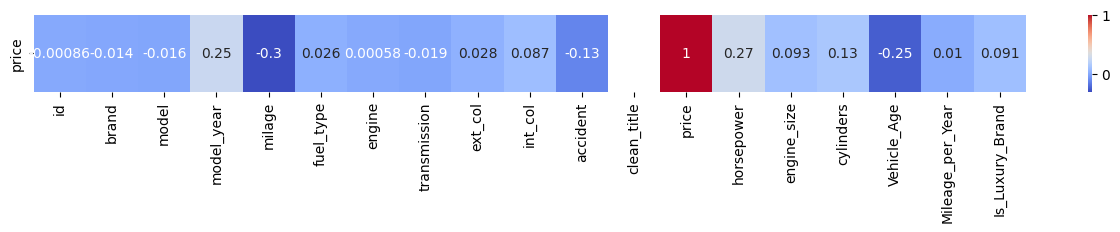

In [17]:
temp=df.dropna()
temp=temp.apply(lambda x : pd.factorize(x)[0] if x.dtype=='object'else x)
plt.figure(figsize=(16,1))
sns.heatmap(temp.corr()[12:13],annot=True,cmap='coolwarm')
plt.show()

In [18]:
df=df.drop(['id','engine','transmission','model_year'],axis=1)
dt=dt.drop(['id','engine','transmission','model_year'],axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   brand             188533 non-null  object 
 1   model             188533 non-null  object 
 2   milage            188533 non-null  int64  
 3   fuel_type         183450 non-null  object 
 4   ext_col           188533 non-null  object 
 5   int_col           188533 non-null  object 
 6   accident          186081 non-null  float64
 7   clean_title       167114 non-null  object 
 8   price             188533 non-null  int64  
 9   horsepower        155274 non-null  float64
 10  engine_size       174319 non-null  float64
 11  cylinders         150678 non-null  float64
 12  Vehicle_Age       188533 non-null  int64  
 13  Mileage_per_Year  188533 non-null  float64
 14  Is_Luxury_Brand   188533 non-null  int64  
dtypes: float64(5), int64(4), object(6)
memory usage: 21.6+ MB


  ## <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Handling Missing and less frequent Values</p>

In [20]:

def cleaning(df, cat_feats, threshold=1):
    for i in cat_feats:
        if df[i].dtype.name == 'category':
            if 'missing' not in df[i].cat.categories:
                df[i] = df[i].cat.add_categories('missing')
            if 'noise' not in df[i].cat.categories:
                df[i] = df[i].cat.add_categories('noise')
        else:
            df[i] = df[i].astype('category')
            df[i] = df[i].cat.add_categories(['missing', 'noise'])
        
        df[i] = df[i].fillna('missing')
        
        count = df[i].value_counts(dropna=False)
        less_freq = count[count < threshold].index
        
        df[i] = df[i].apply(lambda x: 'noise' if x in less_freq else x)
    
    return df
df = cleaning(df, cat_feats)
dt = cleaning(dt, cat_feats) 



In [21]:
cat_feats = ['brand',  'fuel_type',  'ext_col', 'int_col', 'clean_title','model',]  
for col in cat_feats :
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    dt[col] = le.fit_transform(dt[col])  

In [22]:
df.head()

,brand,model,milage,fuel_type,ext_col,int_col,accident,clean_title,price,horsepower,engine_size,cylinders,Vehicle_Age,Mileage_per_Year,Is_Luxury_Brand
0,37,495,213000,2,312,71,0.0,0,4200,172.0,1.6,4.0,17,12529.338063,0
1,28,930,143250,2,263,10,1.0,0,4999,252.0,3.9,8.0,22,6511.334039,0
2,9,1575,136731,1,38,71,0.0,0,13900,320.0,5.3,8.0,22,6215.017204,0
3,15,758,19500,2,29,14,0.0,0,45000,420.0,5.0,8.0,7,2785.674490,1
4,35,1077,7388,2,29,10,0.0,0,97500,208.0,2.0,4.0,3,2462.584581,1


In [23]:
df.isnull().sum(),dt.isnull().sum()

(brand                   0
 model                   0
 milage                  0
 fuel_type               0
 ext_col                 0
 int_col                 0
 accident             2452
 clean_title             0
 price                   0
 horsepower          33259
 engine_size         14214
 cylinders           37855
 Vehicle_Age             0
 Mileage_per_Year        0
 Is_Luxury_Brand         0
 dtype: int64,
 brand                   0
 model                   0
 milage                  0
 fuel_type               0
 ext_col                 0
 int_col                 0
 accident             1632
 clean_title             0
 horsepower          22181
 engine_size          9407
 cylinders           25150
 Vehicle_Age             0
 Mileage_per_Year        0
 Is_Luxury_Brand         0
 dtype: int64)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   brand             188533 non-null  int64  
 1   model             188533 non-null  int64  
 2   milage            188533 non-null  int64  
 3   fuel_type         188533 non-null  int64  
 4   ext_col           188533 non-null  int64  
 5   int_col           188533 non-null  int64  
 6   accident          186081 non-null  float64
 7   clean_title       188533 non-null  int64  
 8   price             188533 non-null  int64  
 9   horsepower        155274 non-null  float64
 10  engine_size       174319 non-null  float64
 11  cylinders         150678 non-null  float64
 12  Vehicle_Age       188533 non-null  int64  
 13  Mileage_per_Year  188533 non-null  float64
 14  Is_Luxury_Brand   188533 non-null  int64  
dtypes: float64(5), int64(10)
memory usage: 21.6 MB


  ## <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Splitting  data</p>

In [25]:
X = df.drop(['price'], axis=1)
X.shape,y.shape

((188533, 14), (188533,))

In [26]:
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X, y, test_size=0.17, random_state=8)

  ## <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Using LGBM with Optuna to find optimal hyperparameters</p>

In [27]:
import xgboost as xgb
def objective(trial):
    # Suggest hyperparameters for tuning
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 160, 780),
        'eta': trial.suggest_loguniform('eta', 0.0005, 0.3),  # learning rate
#         'max_depth':4,
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 10),
        'subsample': trial.suggest_uniform('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.09, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 3, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 10),
        'tree_method': 'hist',  
        'device':'cuda'
    }
    dtrain = xgb.DMatrix(X_train_split, label=y_train_split)
    dvalid = xgb.DMatrix(X_valid_split, label=y_valid_split)
    
    # Train the model
    model = xgb.train(params, dtrain, evals=[(dvalid, 'validation')], num_boost_round=1500, early_stopping_rounds=35, verbose_eval=False)
    
    # Predict on the validation set
    y_pred_valid = model.predict(dvalid)
    
    # Calculate RMSE on the validation set
    rmse = mean_squared_error(y_valid_split, y_pred_valid, squared=False)
    
    return rmse

In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=111)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2024-09-19 04:48:57,343] A new study created in memory with name: no-name-ce4f4604-c186-4eb2-aa3e-d3d7dbafbb53
[I 2024-09-19 04:48:58,445] Trial 0 finished with value: 73104.86284315508 and parameters: {'n_estimators': 280, 'eta': 0.08576501170850521, 'max_depth': 7, 'min_child_weight': 0.08512812203393078, 'subsample': 0.8334091822835574, 'colsample_bytree': 0.7383068867001471, 'lambda': 4.295023874196778, 'alpha': 0.0013803036806753475}. Best is trial 0 with value: 73104.86284315508.
[I 2024-09-19 04:49:02,613] Trial 1 finished with value: 73546.17068389918 and parameters: {'n_estimators': 215, 'eta': 0.002131920611683391, 'max_depth': 4, 'min_child_weight': 0.0027706299423583924, 'subsample': 0.72290887826367, 'colsample_bytree': 0.30954287196804897, 'lambda': 5.815773828605984, 'alpha': 0.05831825509605863}. Best is trial 0 with value: 73104.86284315508.
[I 2024-09-19 04:49:10,355] Trial 2 finished with value: 75003.17294936214 and parameters: {'n_estimators': 261, 'eta': 0.0005

Best hyperparameters: {'n_estimators': 552, 'eta': 0.011004056473354439, 'max_depth': 6, 'min_child_weight': 0.04449062097239026, 'subsample': 0.8906834392066515, 'colsample_bytree': 0.46778001579669276, 'lambda': 8.998014599226886, 'alpha': 0.20186143347983934}


In [29]:
# best_params={'n_estimators': 1075, 'eta': 0.006322676490697651, 'max_depth': 4, 'min_child_weight': 0.00395187090807294, 'subsample': 0.9313710525668728, 'colsample_bytree': 0.5484624100206377, 'lambda': 7.740721556692922, 'alpha': 0.3158771161140435}

  ## <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Training model on best Parameters</p>

In [30]:
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'
best_params['eval_metric'] = 'rmse'
best_params['device'] = 'cuda'
dtrain = xgb.DMatrix(X, label=y)
model = xgb.train(best_params, dtrain, num_boost_round=1500)

  ## <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Predicting Test.csv</p>

In [31]:
dtest = xgb.DMatrix(dt)  
pred = model.predict(dtest)

id = sf.pop('id')

# Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': id,
    'class': pred
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_xgb1.csv', index=False)
print("Submission file created: submission_xgb1.csv")

Submission file created: submission_xgb1.csv
